In [38]:
# Add MOSQITO to the Python path
import sys
import os
sys.path.append('..')

# Import numpy
import numpy as np
import pandas as pd
# Import plot function
import matplotlib.pyplot as plt
# Import mosqito functions
#from mosqito.utils import load
from mosqito.sq_metrics import loudness_zwtv, sharpness_din_tv, roughness_dw, pr_ecma_tv, tnr_ecma_tv
from scipy.io import wavfile
from scipy.signal import resample
from maad.spl import pressure2leq, pressure2dBSPL
from maad.util import mean_dB
import librosa

# Import MOSQITO color sheme [Optional]
from mosqito import COLORS

from scipy.signal import lfilter
from scipy.signal.filter_design import bilinear
from numpy import pi, convolve

def A_weighting(Fs):
    """Design of an A-weighting filter.
    
    B, A = A_weighting(Fs) designs a digital A-weighting filter for 
    sampling frequency Fs. Usage: y = lfilter(B, A, x).
    Warning: Fs should normally be higher than 20 kHz. For example, 
    Fs = 48000 yields a class 1-compliant filter.
    
    Originally a MATLAB script. Also included ASPEC, CDSGN, CSPEC.
    
    Author: Christophe Couvreur, Faculte Polytechnique de Mons (Belgium)
            couvreur@thor.fpms.ac.be
    Last modification: Aug. 20, 1997, 10:00am.
    
    http://www.mathworks.com/matlabcentral/fileexchange/69
    http://replaygain.hydrogenaudio.org/mfiles/adsgn.m
    Translated from adsgn.m to PyLab 2009-07-14 endolith@gmail.com
    
    References: 
       [1] IEC/CD 1672: Electroacoustics-Sound Level Meters, Nov. 1996.
    
    """
    # Definition of analog A-weighting filter according to IEC/CD 1672.
    f1 = 20.598997
    f2 = 107.65265
    f3 = 737.86223
    f4 = 12194.217
    A1000 = 1.9997
    
    NUMs = [(2 * pi * f4)**2 * (10**(A1000/20)), 0, 0, 0, 0]
    DENs = convolve([1, +4 * pi * f4, (2 * pi * f4)**2], 
                    [1, +4 * pi * f1, (2 * pi * f1)**2], mode='full')
    DENs = convolve(convolve(DENs, [1, 2 * pi * f3], mode='full'), 
                                   [1, 2 * pi * f2], mode='full')
    
    # Use the bilinear transformation to get the digital filter.
    # (Octave, MATLAB, and PyLab disagree about Fs vs 1/Fs)
    return bilinear(NUMs, DENs, Fs)


/var/folders/87/rtp1hhtx2tgcw5x4mgt4m00m0000gn/T/ipykernel_11511/578462497.py:24: DeprecationWarning: Please use `bilinear` from the `scipy.signal` namespace, the `scipy.signal.filter_design` namespace is deprecated.
  from scipy.signal.filter_design import bilinear


In [2]:
def load(file, wav_calib=None, mat_signal="", mat_fs="", ch=None):
    """Extract the signal and its time axis from .wav or .uff file,
    resample the signal to 48 kHz, and affects its sampling frequency
    and time signal values.

    Parameters
    ----------
    file : string
        string path to the signal file
    wav_calib : float, optional
        Wav file calibration factor [Pa/FS]. Level of the signal in Pa_peak
        corresponding to the full scale of the .wav file. If None, a
        calibration factor of 1 is considered. Default to None.
    mat_signal : string
        in case of a .mat file, name of the signal variable
    mat_fs : string
        in case of a .mat file, name of the sampling frequency variable

    Outputs
    -------
    signal : numpy.array
        time signal values
    fs : integer
        sampling frequency
    """

    # load the .wav file content
    if file[-3:] == "wav" or file[-3:] == "WAV":
        fs, signal = wavfile.read(file)

        # manage multichannel files
        if signal.ndim > 1:
            signal = signal[:, ch] # signal[:, 0] for first channel, signal[:, 1] for second ch

        # calibration factor for the signal to be in Pa
        if wav_calib is None:
            wav_calib = 1
            print("[Info] A calibration of 1 Pa/FS is considered")
        if isinstance(signal[0], np.int16):
            signal = wav_calib * signal / (2**15 - 1)
        elif isinstance(signal[0], np.int32):
            signal = wav_calib * signal / (2**31 - 1)
        elif isinstance(signal[0], np.float):
            signal = wav_calib * signal

    else:
        raise ValueError("""ERROR: only .wav .mat or .uff files are supported""")

    # resample to 48kHz to allow calculation
    if fs != 48000:
        signal = resample(signal, int(48000 * len(signal) / fs))
        fs = 48000

    return signal, fs


In [108]:
# Load csv with data
data_augmented = pd.read_csv("../data/responses.csv")
data_generated = pd.read_csv("../data/generated.csv")
# Prepare dataframe for new features
column_names = [
     'Navg_r', 
     'Nrmc_r', 
     'Nmax_r', 
     'Nargmax_r', 
     'N05_r', 
     'N10_r', 
     'N20_r',
     'N30_r', 
     'N40_r', 
     'N50_r', 
     'N60_r', 
     'N70_r', 
     'N80_r', 
     'N90_r', 
     'N95_r'
    ]
column_names=["LAavg_r", "LAmin_r", "LAargmin_r", "LAmax_r", "LAargmax_r", 
    "LA05_r", "LA10_r", "LA20_r", "LA30_r", "LA40_r", 
    "LA50_r", "LA60_r", "LA70_r", "LA80_r", "LA90_r", "LA95_r",'Navg_r', 
     'Nrmc_r', 
     'Nmax_r', 
     'Nargmax_r', 
     'N05_r', 
     'N10_r', 
     'N20_r',
     'N30_r', 
     'N40_r', 
     'N50_r', 
     'N60_r', 
     'N70_r', 
     'N80_r', 
     'N90_r', 
     'N95_r']
column_aug = [
    "participant", "fold_r", "soundscape", "masker", "smr", "stimulus_index", "time_taken", "is_attention", 
    "pleasant", "eventful", "chaotic", "vibrant", "uneventful", "calm", "annoying", "monotonous", 
    "appropriate", "Savg_r", "Smax_r", "Sargmax_r", "S05_r", "S10_r", "S20_r", "S30_r", "S40_r", 
    "S50_r", "S60_r", "S70_r", "S80_r", "S90_r", "S95_r", "Navg_r", "Nrmc_r", "Nmax_r", "Nargmax_r", 
    "N05_r", "N10_r", "N20_r", "N30_r", "N40_r", "N50_r", "N60_r", "N70_r", "N80_r", "N90_r", "N95_r", 
    "Favg_r", "Fmax_r", "Fargmax_r", "F05_r", "F10_r", "F20_r", "F30_r", "F40_r", "F50_r", "F60_r", 
    "F70_r", "F80_r", "F90_r", "F95_r", "LAavg_r", "LAmin_r", "LAargmin_r", "LAmax_r", "LAargmax_r", 
    "LA05_r", "LA10_r", "LA20_r", "LA30_r", "LA40_r", "LA50_r", "LA60_r", "LA70_r", "LA80_r", "LA90_r", 
    "LA95_r", "LCavg_r", "LCmin_r", "LCargmin_r", "LCmax_r", "LCargmax_r", "LC05_r", "LC10_r", "LC20_r", 
    "LC30_r", "LC40_r", "LC50_r", "LC60_r", "LC70_r", "LC80_r", "LC90_r", "LC95_r", "Ravg_r", "Rmax_r", 
    "Rargmax_r", "R05_r", "R10_r", "R20_r", "R30_r", "R40_r", "R50_r", "R60_r", "R70_r", "R80_r", "R90_r", 
    "R95_r", "Tgavg_r", "Tavg_r", "Tmax_r", "Targmax_r", "T05_r", "T10_r", "T20_r", "T30_r", "T40_r", 
    "T50_r", "T60_r", "T70_r", "T80_r", "T90_r", "T95_r", "M00005_0_r", "M00006_3_r", "M00008_0_r", 
    "M00010_0_r", "M00012_5_r", "M00016_0_r", "M00020_0_r", "M00025_0_r", "M00031_5_r", "M00040_0_r", 
    "M00050_0_r", "M00063_0_r", "M00080_0_r", "M00100_0_r", "M00125_0_r", "M00160_0_r", "M00200_0_r", 
    "M00250_0_r", "M00315_0_r", "M00400_0_r", "M00500_0_r", "M00630_0_r", "M00800_0_r", "M01000_0_r", 
    "M01250_0_r", "M01600_0_r", "M02000_0_r", "M02500_0_r", "M03150_0_r", "M04000_0_r", "M05000_0_r", 
    "M06300_0_r", "M08000_0_r", "M10000_0_r", "M12500_0_r", "M16000_0_r", "M20000_0_r", "Leq_L_r", "Leq_R_r"
]

""" 'Savg_s', 'Smax_s', 'Sargmax_s', 'S05_s', 'S10_s', 'S20_s', 'S30_s', 'S40_s', 'S50_s', 'S60_s', 
    'S70_s', 'S80_s', 'S90_s', 'S95_s', , 'Favg_s', 'Fmax_s', 
    'Fargmax_s', 'F05_s', 'F10_s', 'F20_s', 'F30_s', 'F40_s', 'F50_s', 'F60_s', 'F70_s', 'F80_s', 'F90_s', 
    'F95_s', 'LAavg_s', 'LAmin_s', 'LAargmin_s', 'LAmax_s', 'LAargmax_s', 'LA05_s', 'LA10_s', 'LA20_s', 
    'LA30_s', 'LA40_s', 'LA50_s', 'LA60_s', 'LA70_s', 'LA80_s', 'LA90_s', 'LA95_s', 'LCavg_s', 'LCmin_s', 
    'LCargmin_s', 'LCmax_s', 'LCargmax_s', 'LC05_s', 'LC10_s', 'LC20_s', 'LC30_s', 'LC40_s', 'LC50_s', 
    'LC60_s', 'LC70_s', 'LC80_s', 'LC90_s', 'LC95_s', 'Ravg_s', 'Rmax_s', 'Rargmax_s', 'R05_s', 'R10_s', 
    'R20_s', 'R30_s', 'R40_s', 'R50_s', 'R60_s', 'R70_s', 'R80_s', 'R90_s', 'R95_s', 'Tgavg_s', 'Tavg_s', 
    'Tmax_s', 'Targmax_s', 'T05_s', 'T10_s', 'T20_s', 'T30_s', 'T40_s', 'T50_s', 'T60_s', 'T70_s', 'T80_s', 
    'T90_s', 'T95_s', 'M00005_0_s', 'M00006_3_s', 'M00008_0_s', 'M00010_0_s', 'M00012_5_s', 'M00016_0_s', 
    'M00020_0_s', 'M00025_0_s', 'M00031_5_s', 'M00040_0_s', 'M00050_0_s', 'M00063_0_s', 'M00080_0_s', 
    'M00100_0_s', 'M00125_0_s', 'M00160_0_s', 'M00200_0_s', 'M00250_0_s', 'M00315_0_s', 'M00400_0_s', 
    'M00500_0_s', 'M00630_0_s', 'M00800_0_s', 'M01000_0_s', 'M01250_0_s', 'M01600_0_s', 'M02000_0_s', 
    'M02500_0_s', 'M03150_0_s', 'M04000_0_s', 'M05000_0_s', 'M06300_0_s', 'M08000_0_s', 'M10000_0_s', 
    'M12500_0_s', 'M16000_0_s', 'M20000_0_s' """
new_df = pd.DataFrame(columns=column_names)
aug_df = pd.DataFrame(columns=column_aug)
# For each audio...
audios_path = "../data/soundscapes_augmented/"
for file in sorted(os.listdir(audios_path)):
        if file.endswith('.mp3') or file.endswith('.wav'):
            print("FILEEEEEEEEEE ", file)
            # audio path
            audio_path=audios_path+file
            # Find the row where the filename matches in the "soundscape" column
            file_split=file.split("_")
            file_fold=int(file_split[1])
            file_participant="ARAUS_"+file_split[3]
            file_stimulus=int(file_split[5].split(".")[0])
            audio_info_aug = data_augmented[data_augmented['fold_r'] == file_fold]
            audio_info_aug = audio_info_aug[audio_info_aug['stimulus_index'] == file_stimulus]
            audio_info_aug = audio_info_aug[audio_info_aug['participant'] == file_participant] # Row of info from responses.csv
            soundscape=audio_info_aug['soundscape'].values[0]
            audio_info_gen = data_generated[data_generated['soundscape_file'] == soundscape] # Row of info form generated.csv
            print("audio sounscape ", soundscape)

            #Get Leq of raw digital audio to calculate audio gain needed
            rawR, fs = load(audio_path, wav_calib=1, ch=1) #R
            rawR_Leq_avg=mean_dB(pressure2leq(rawR, fs, 0.125))
            trueLeq=audio_info_aug["Leq_R_r"].values[0]
            difference=trueLeq-rawR_Leq_avg
            audio_gain=10**(difference/20)
            print(audio_gain, " gain factor")


            # Get gain

            #audio_gain=float(audio_info_gen['gain'].values[0])
            #audio_gain=4.6*audio_gain/0.759272
            # Load L and R channels
            #sigL, fs = load(audio_path, wav_calib=audio_gain, ch=0) #L
            sigR, fs = load(audio_path, wav_calib=audio_gain, ch=1) #R


            # Calculate LAeqLAeq

            [B_A,A_A] = A_weighting(fs)
            sigR_A = lfilter(B_A,A_A,sigR)
            LAeq_r=pressure2leq(sigR_A, fs, 0.125)

            LA_avg_s =mean_dB(LAeq_r)
            LA_max_s =np.max(LAeq_r)
            LA_min_s =np.min(LAeq_r)
            LA_05_s =np.percentile(LAeq_r,95)
            LA_10_s =np.percentile(LAeq_r,90)
            LA_20_s =np.percentile(LAeq_r,80)
            LA_30_s =np.percentile(LAeq_r,70)
            LA_40_s =np.percentile(LAeq_r,60)
            LA_50_s =np.percentile(LAeq_r,50)
            LA_60_s =np.percentile(LAeq_r,40)
            LA_70_s =np.percentile(LAeq_r,30)
            LA_80_s =np.percentile(LAeq_r,20)
            LA_90_s =np.percentile(LAeq_r,10)
            LA_95_s =np.percentile(LAeq_r,5)


            
            # Calculate loudness
            ## L
            #N_l, N_spec_l, bark_axis_l, time_axis_l = loudness_zwtv(sigL, fs, field_type="free")
            # R
            N_r, N_spec_r, bark_axis_r, time_axis_r = loudness_zwtv(sigR, fs, field_type="free")
            ## S
            N_avg_s=(np.mean(N_r))
            N_max_s=(np.max(N_r))
            N_05_s=(np.percentile(N_r,95))
            N_10_s=(np.percentile(N_r,90))
            N_20_s=(np.percentile(N_r,80))
            N_30_s=(np.percentile(N_r,70))
            N_40_s=(np.percentile(N_r,60))
            N_50_s=(np.percentile(N_r,50))
            N_60_s=(np.percentile(N_r,40))
            N_70_s=(np.percentile(N_r,30))
            N_80_s=(np.percentile(N_r,20))
            N_90_s=(np.percentile(N_r,10))
            N_95_s=(np.percentile(N_r,5))
            

            # Add all data to entry
            entry = {
                'soundscape': file,
                'gain': audio_gain,
                'LAavg_r': LA_avg_s,
                'LAmin_r': LA_min_s,
                'LAargmin_r': 0,
                'LAmax_r': LA_max_s,
                'LAargmax_r': 0,
                'LA05_r': LA_05_s,
                'LA10_r': LA_10_s,
                'LA20_r': LA_20_s,
                'LA30_r': LA_30_s,
                'LA40_r': LA_40_s,
                'LA50_r': LA_50_s,
                'LA60_r': LA_60_s,
                'LA70_r': LA_70_s,
                'LA80_r': LA_80_s,
                'LA90_r': LA_90_s,
                'LA95_r': LA_95_s,
                'Navg_r': N_avg_s,
                'Nrmc_r': 0,
                'Nmax_r': N_max_s,
                'Nargmax_r': 0,
                'N05_r': N_05_s,
                'N10_r': N_10_s,
                'N20_r': N_20_s,
                'N30_r': N_30_s,
                'N40_r': N_40_s,
                'N50_r': N_50_s,
                'N60_r': N_60_s,
                'N70_r': N_70_s,
                'N80_r': N_80_s,
                'N90_r': N_90_s,
                'N95_r': N_95_s
                }
            
            new_df = pd.concat([new_df, pd.DataFrame([entry])], ignore_index=True)
            aug_df = pd.concat([aug_df, pd.DataFrame(audio_info_aug)], ignore_index=True)

            print("File done ", file)

FILEEEEEEEEEE  fold_1_participant_00001_stimulus_02.wav
audio sounscape  R0079_segment_binaural_44100_1.wav
4.902478604995405  gain factor


/var/folders/87/rtp1hhtx2tgcw5x4mgt4m00m0000gn/T/ipykernel_11511/3969321254.py:195: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  new_df = pd.concat([new_df, pd.DataFrame([entry])], ignore_index=True)
/var/folders/87/rtp1hhtx2tgcw5x4mgt4m00m0000gn/T/ipykernel_11511/3969321254.py:196: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  aug_df = pd.concat([aug_df, pd.DataFrame(audio_info_aug)], ignore_index=True)


File done  fold_1_participant_00001_stimulus_02.wav
FILEEEEEEEEEE  fold_1_participant_00001_stimulus_03.wav
audio sounscape  R0056_segment_binaural_44100_2.wav
4.04493175943394  gain factor
File done  fold_1_participant_00001_stimulus_03.wav
FILEEEEEEEEEE  fold_1_participant_00001_stimulus_04.wav
audio sounscape  R0046_segment_binaural_44100_2.wav
5.255976063836467  gain factor
File done  fold_1_participant_00001_stimulus_04.wav
FILEEEEEEEEEE  fold_1_participant_00001_stimulus_05.wav
audio sounscape  R0092_segment_binaural_44100_1.wav
9.141566535200297  gain factor
File done  fold_1_participant_00001_stimulus_05.wav
FILEEEEEEEEEE  fold_1_participant_00001_stimulus_06.wav
audio sounscape  R0126_segment_binaural_44100_1.wav
7.999802384804103  gain factor
File done  fold_1_participant_00001_stimulus_06.wav
FILEEEEEEEEEE  fold_1_participant_00001_stimulus_07.wav
audio sounscape  R0095_segment_binaural_44100_2.wav
4.683705188925235  gain factor
File done  fold_1_participant_00001_stimulus_0

LAavg_r


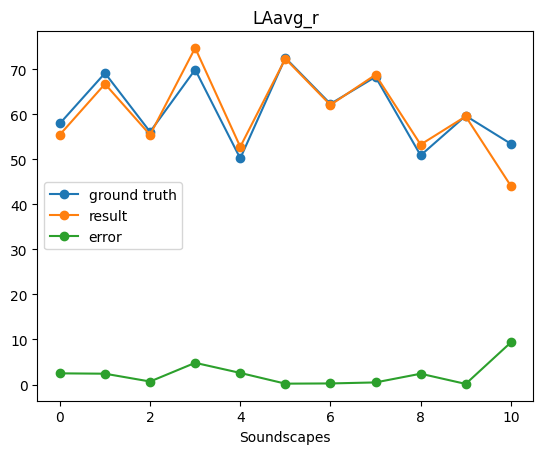

LAmin_r


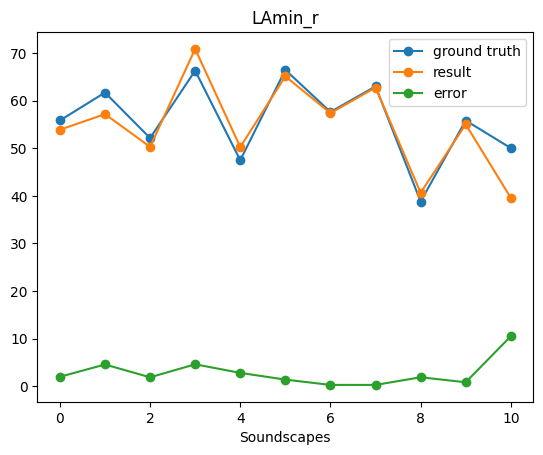

LAargmin_r


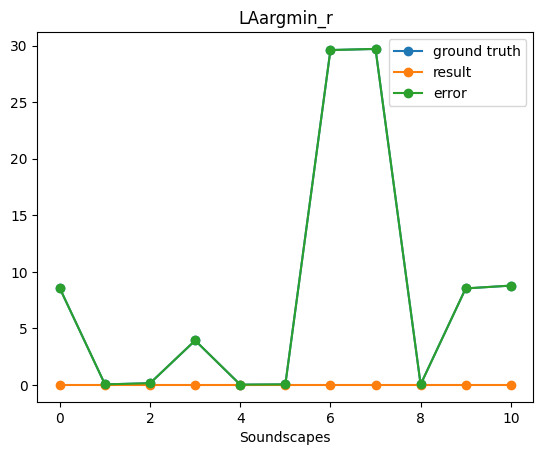

LAmax_r


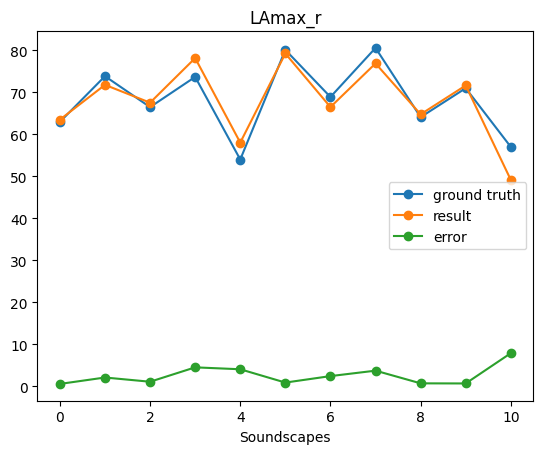

LAargmax_r


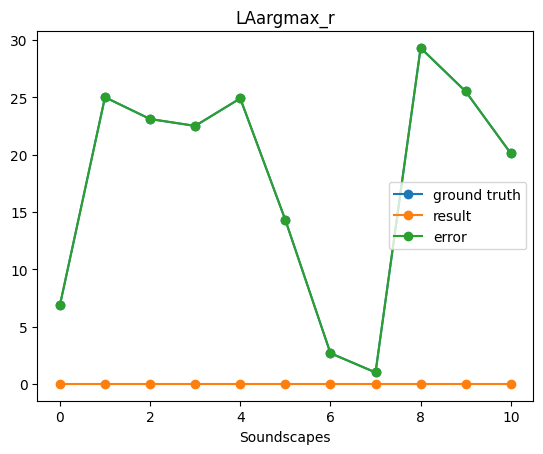

LA05_r


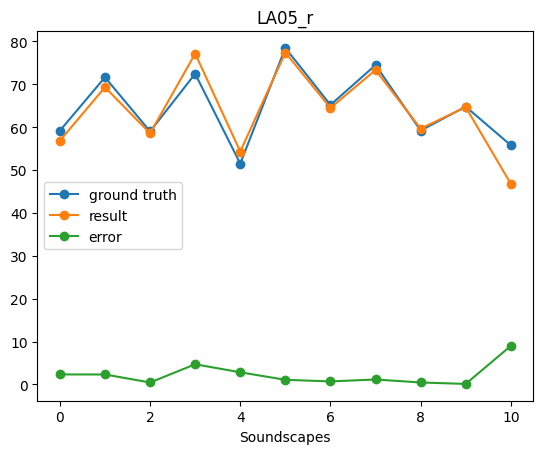

LA10_r


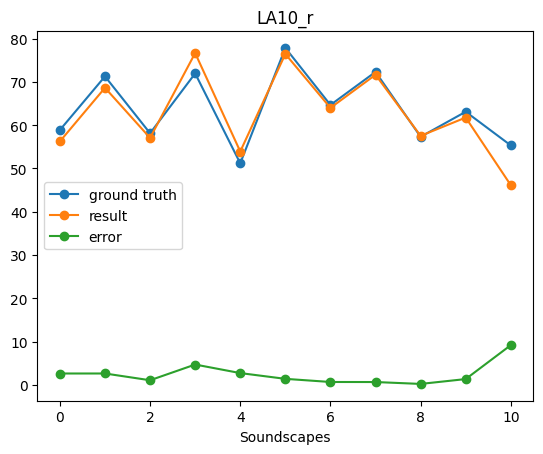

LA20_r


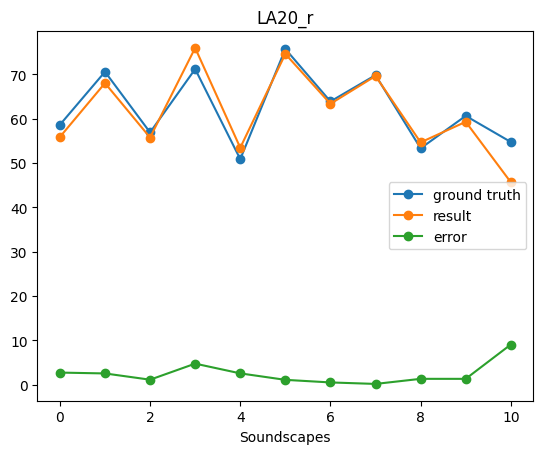

LA30_r


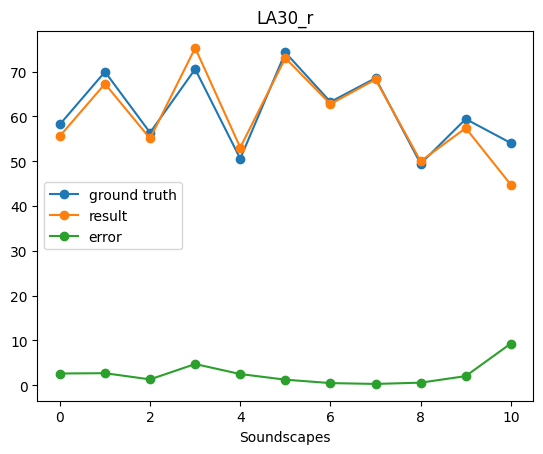

LA40_r


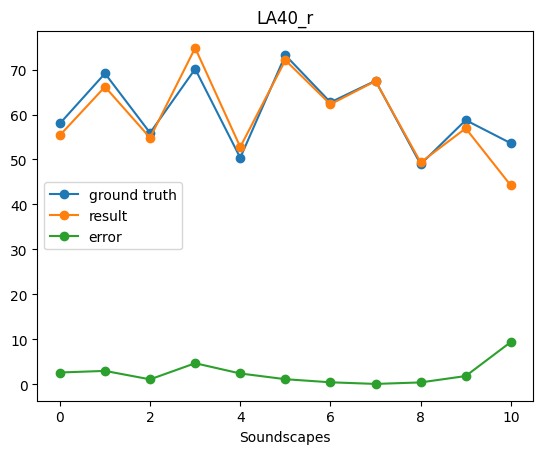

LA50_r


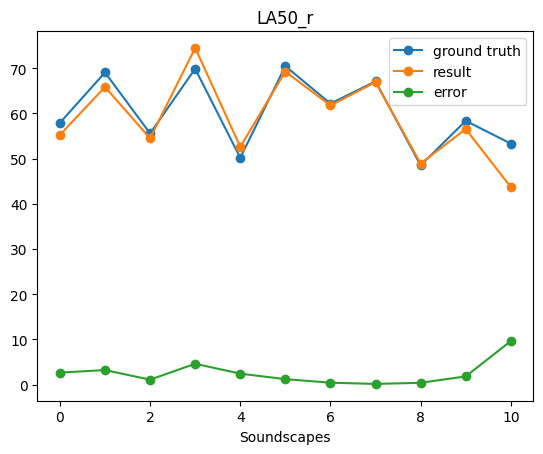

LA60_r


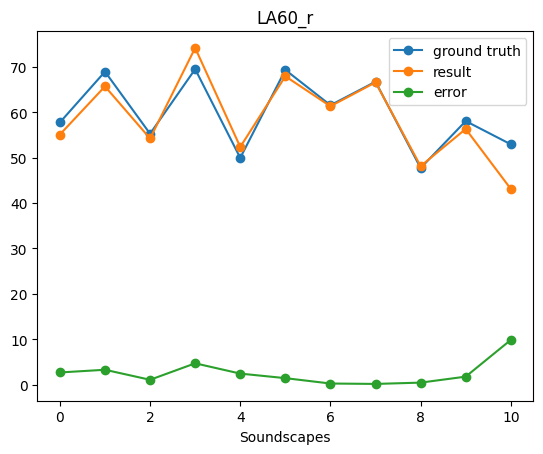

LA70_r


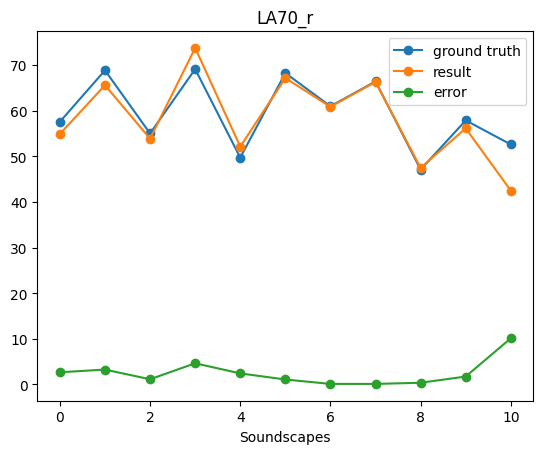

LA80_r


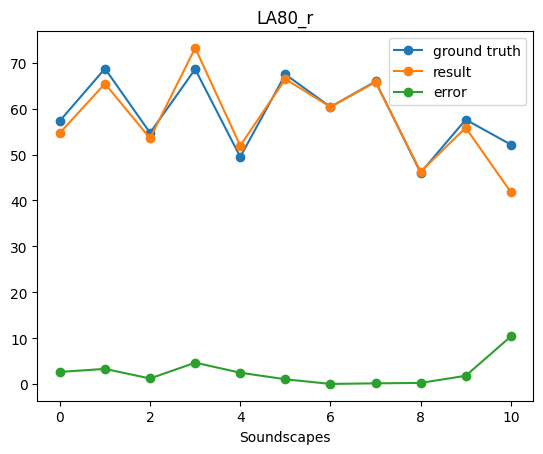

LA90_r


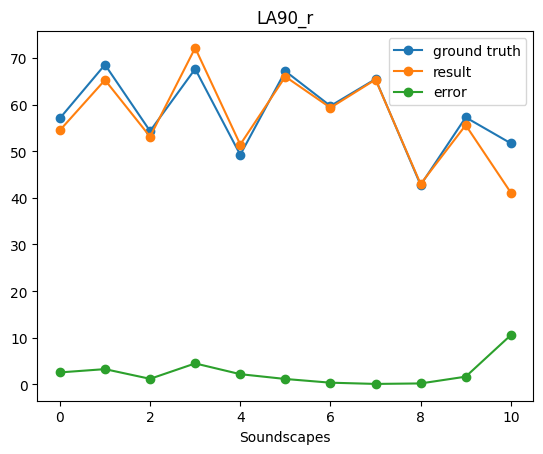

LA95_r


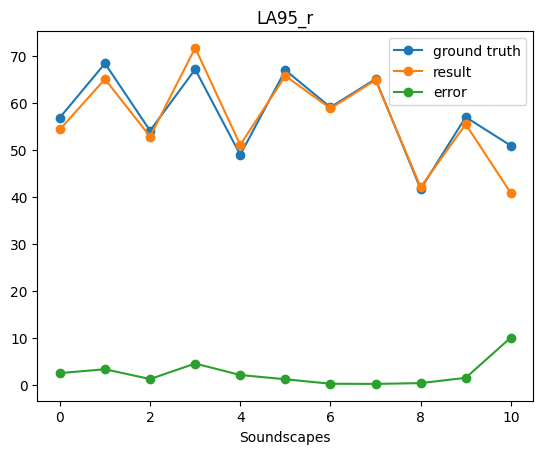

Navg_r


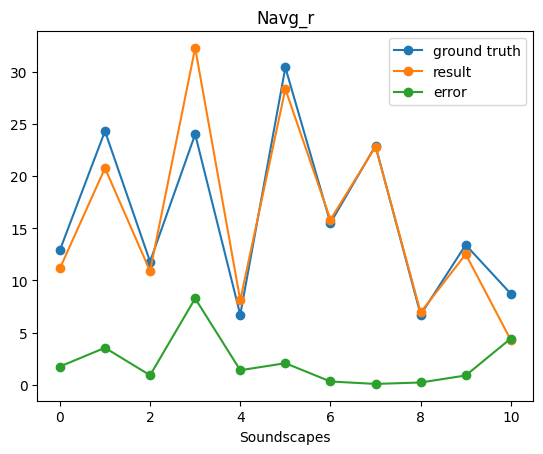

Nrmc_r


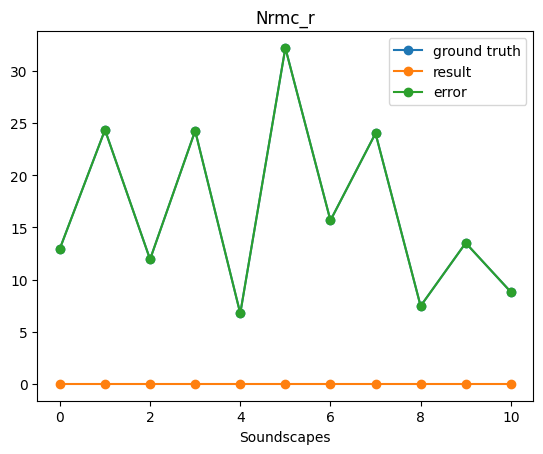

Nmax_r


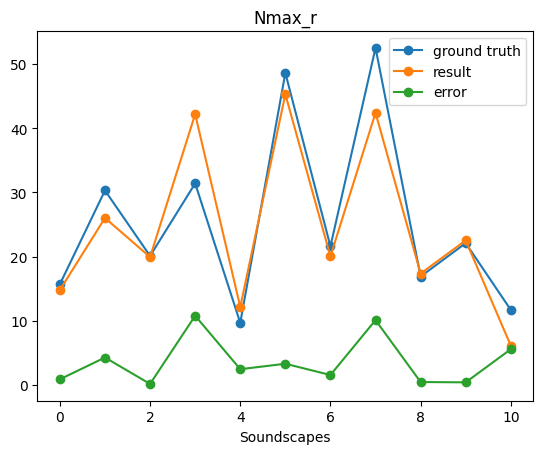

Nargmax_r


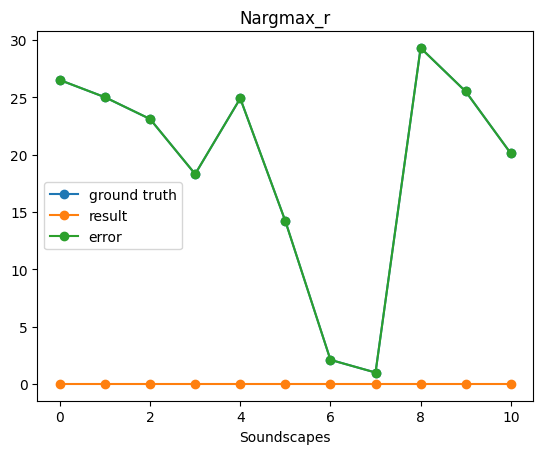

N05_r


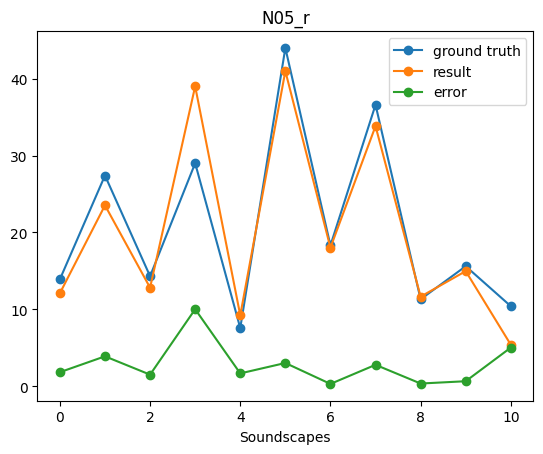

N10_r


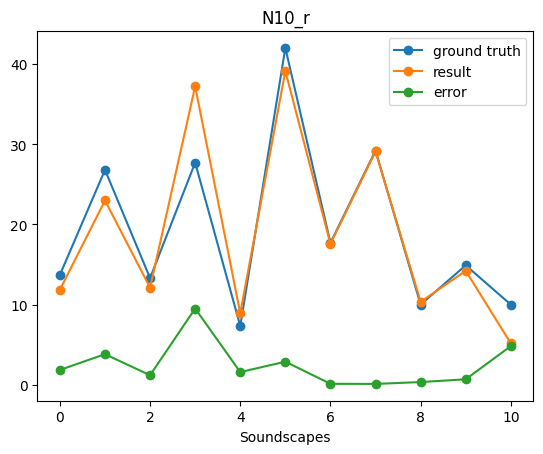

N20_r


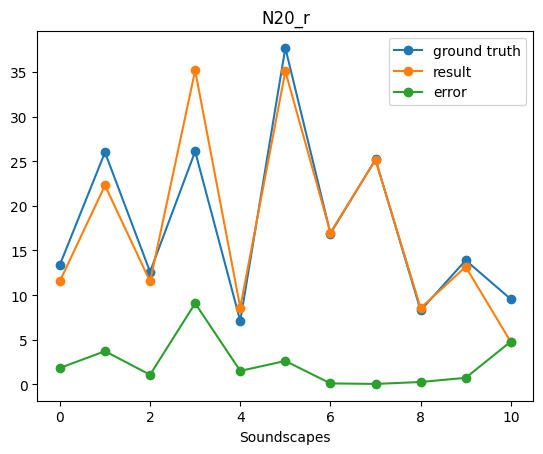

N30_r


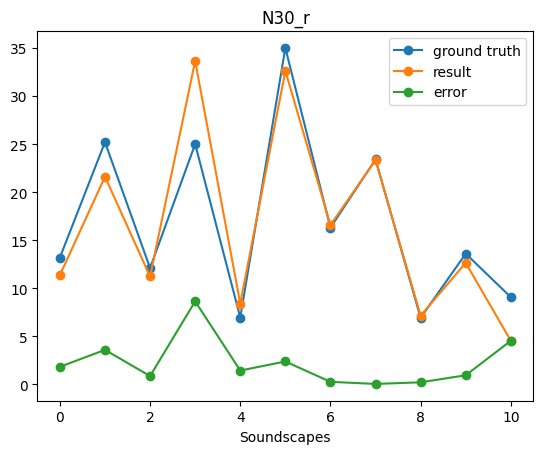

N40_r


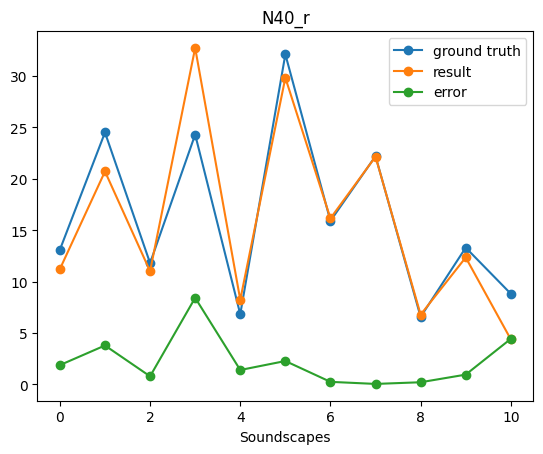

N50_r


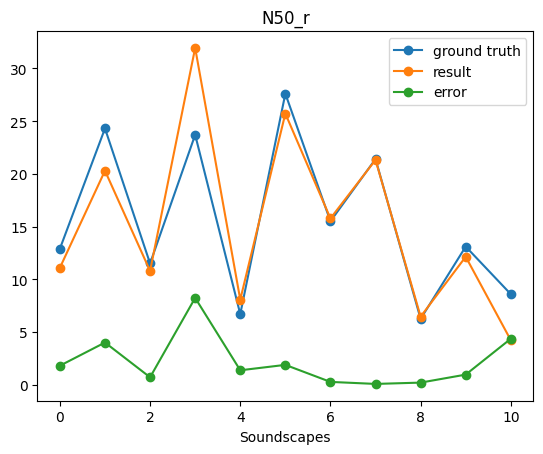

N60_r


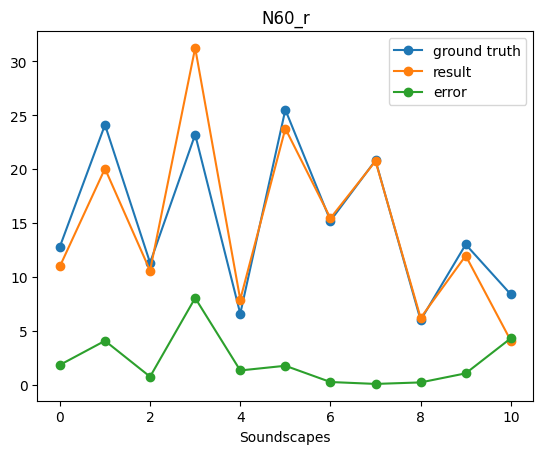

N70_r


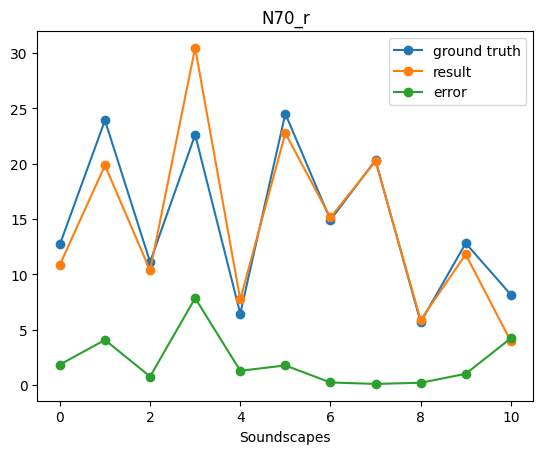

N80_r


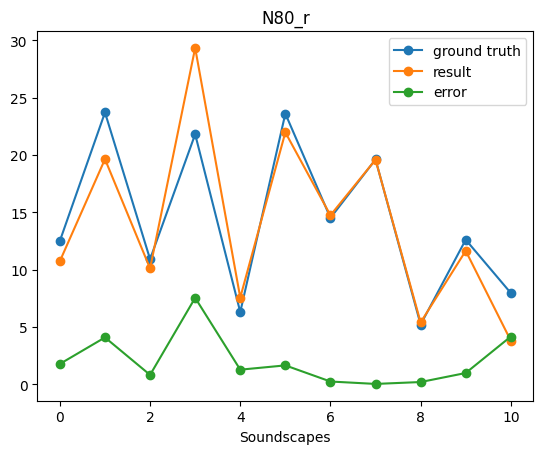

N90_r


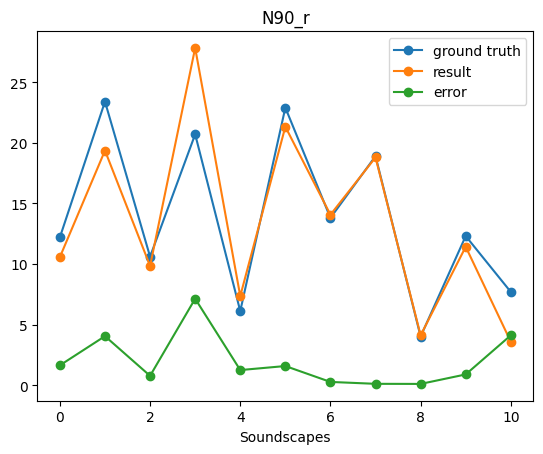

N95_r


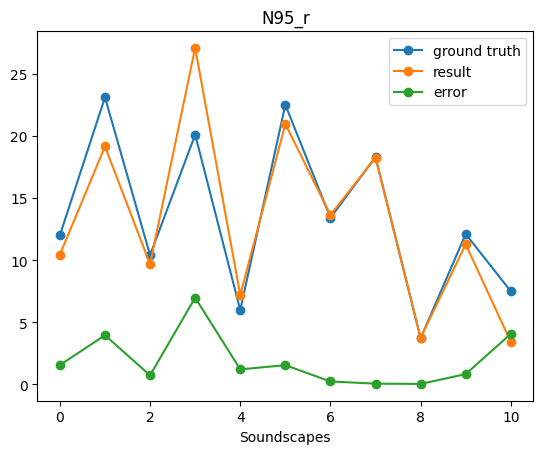

In [109]:
for feature in column_names:
    print(feature)
    if((feature!="soundscape" or feature!="gain")):             
        plt.plot(aug_df[feature], "o-", label="ground truth")
        plt.plot(new_df[feature], "o-", label="result")
        error=np.abs(aug_df[feature]-new_df[feature])
        plt.plot(error, "o-", label="error")
        plt.xlabel('Soundscapes')
        plt.title(feature)
        plt.legend()
        plt.show() 

In [ ]:
audios_path = "../data/soundscapes/"

audio_gain=4.6
# Load L and R channels
#sigL, fs = load(audio_path, wav_calib=audio_gain, ch=0) #L
sigR, fs = load(audio_path, wav_calib=audio_gain, ch=1) #R


# Calculate LAeqLAeq

[B_A,A_A] = A_weighting(fs)
sigR_A = lfilter(B_A,A_A,sigR)
LAeq_r=pressure2leq(sigR_A, fs, 0.125)

In [85]:
def cost_function(current_LAavg, current_LAmax, current_LA05, desired_LAavg, desired_LAmax, desired_LA05):
    cost=( np.abs(np.abs(desired_LAavg-current_LAavg))
        +np.abs(np.abs(desired_LAmax-current_LAmax))
        +np.abs(np.abs(desired_LA05-current_LA05)))
    return cost
ground_truth = [60.62, 58.98, 23.8, 67.72, 7.2, 63.53, 61.45, 60.7, 60.49, 60.34, 60.21, 60.06, 59.91, 59.76, 59.6, 59.49]

cost=100
gain=4.6
LA_avg_true=ground_truth[0]
LA_max_true=ground_truth[3]
LA_05_true=ground_truth[5]
iteration=0
while cost>0.1 and iteration<10:
    print(iteration)
    # LOAD R0001_segment_binaural_44100_1.wav
    path = "../data/soundscapes_augmented/fold_2_participant_00002_stimulus_11.wav"
    sigR, fs = load(path, wav_calib=gain, ch=1) #R

    # Calculate LAeqLAeq

    [B_A,A_A] = A_weighting(fs)
    sigR_A = lfilter(B_A,A_A,sigR)
    LAeq_r=pressure2leq(sigR_A, fs, 0.125)

    LA_avg_r =mean_dB(LAeq_r)
    LA_max_r =np.max(LAeq_r)
    LA_min_r =np.min(LAeq_r)
    LA_05_r =np.percentile(LAeq_r,95)
    LA_10_r =np.percentile(LAeq_r,90)
    LA_20_r =np.percentile(LAeq_r,80)
    LA_30_r =np.percentile(LAeq_r,70)
    LA_40_r =np.percentile(LAeq_r,60)
    LA_50_r =np.percentile(LAeq_r,50)
    LA_60_r =np.percentile(LAeq_r,40)
    LA_70_r =np.percentile(LAeq_r,30)
    LA_80_r =np.percentile(LAeq_r,20)
    LA_90_r =np.percentile(LAeq_r,10)
    LA_95_r =np.percentile(LAeq_r,5)


    cost=cost_function(LA_avg_r, LA_max_r, LA_05_r, LA_avg_true, LA_max_true, LA_05_true)
    
    print("Current Error ", cost)
    iteration=iteration+1
    gain=gain

print("Found! Gain is ", gain, " with error ", cost)


0
Current Error  12.649686021533064
1
Current Error  12.649686021533064
2
Current Error  12.649686021533064
3
Current Error  12.649686021533064
4
Current Error  12.649686021533064
5
Current Error  12.649686021533064
6
Current Error  12.649686021533064
7
Current Error  12.649686021533064
8
Current Error  12.649686021533064
9
Current Error  12.649686021533064
Found! Gain is  4.6  with error  12.649686021533064
